In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def remove_crl_male(df):
    max=39
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

def remove_crl_female(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age','pseudo_age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl_male(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd['remapped_bins'] = m_psd['pseudo_age']
m_psd.set_index(['remapped_bins'], 
                append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [6]:
# arrange data
# pseudo data females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_pseudotime_v02.parquet')
f_psd = pd.read_parquet(path)
f_psd=f_psd.reset_index()
f_psd=f_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the female dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_v2.parquet')
df_females = pd.read_parquet(path)
df_females = remove_crl_female(df_females)
f_psd = df_females.merge(f_psd, on='uuid', how='left')

#do some cleaning up
f_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
f_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
f_psd = f_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
f_psd['bins'] = pd.qcut(f_psd.index.get_level_values('psd'), len(f_psd.index.get_level_values('age').unique()),labels=False)

ages = f_psd.index.get_level_values('age').unique().to_numpy()
mapdr_females = dict(zip(list(range(len(ages))), ages))
y_temp = f_psd['bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]

f_psd['remapped_bins'] = y_temp
f_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [7]:
# pseudo regression
from sklearn.cross_decomposition import PLSRegression
from sklearn import neighbors
mdl= neighbors.KNeighborsRegressor(n_neighbors=8)
#mdl = PLSRegression(n_components=3)
x = m_psd.filter(regex=r'\d')
y = x.index.get_level_values('psd')
mdl.fit(x, y)
print(mdl.score(x, y))

#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
x = f_psd.filter(regex=r'\d')
psd=mdl.predict(x)

0.9782308974978633


In [8]:
# add female psd projected on males
f_psd['proj_psd'] = psd
f_psd['proj_bins'] = pd.qcut(f_psd.proj_psd, len(f_psd.index.get_level_values('age').unique()),labels=False)
y_temp = f_psd['proj_bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]

f_psd['proj_remapped_bins'] = y_temp
f_psd.set_index(['proj_psd','proj_bins','proj_remapped_bins'], 
                append=True, inplace=True)

In [9]:
f_data=f_psd.copy()
m_data=m_psd.copy()

In [10]:
data = f_data.groupby('remapped_bins').mean().copy()
data_labels = data.index.get_level_values('remapped_bins').to_numpy()
data_umap= data.to_numpy().T

In [11]:
# clustering for individuals
frequencies = data_umap

#scaling the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(frequencies)

nclust=5 
kmeans_kwargs = {"init": "random",
                "n_init": 20,
                "max_iter": 300,
                "random_state":10}

IndexError: index 3 is out of bounds for axis 0 with size 3

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

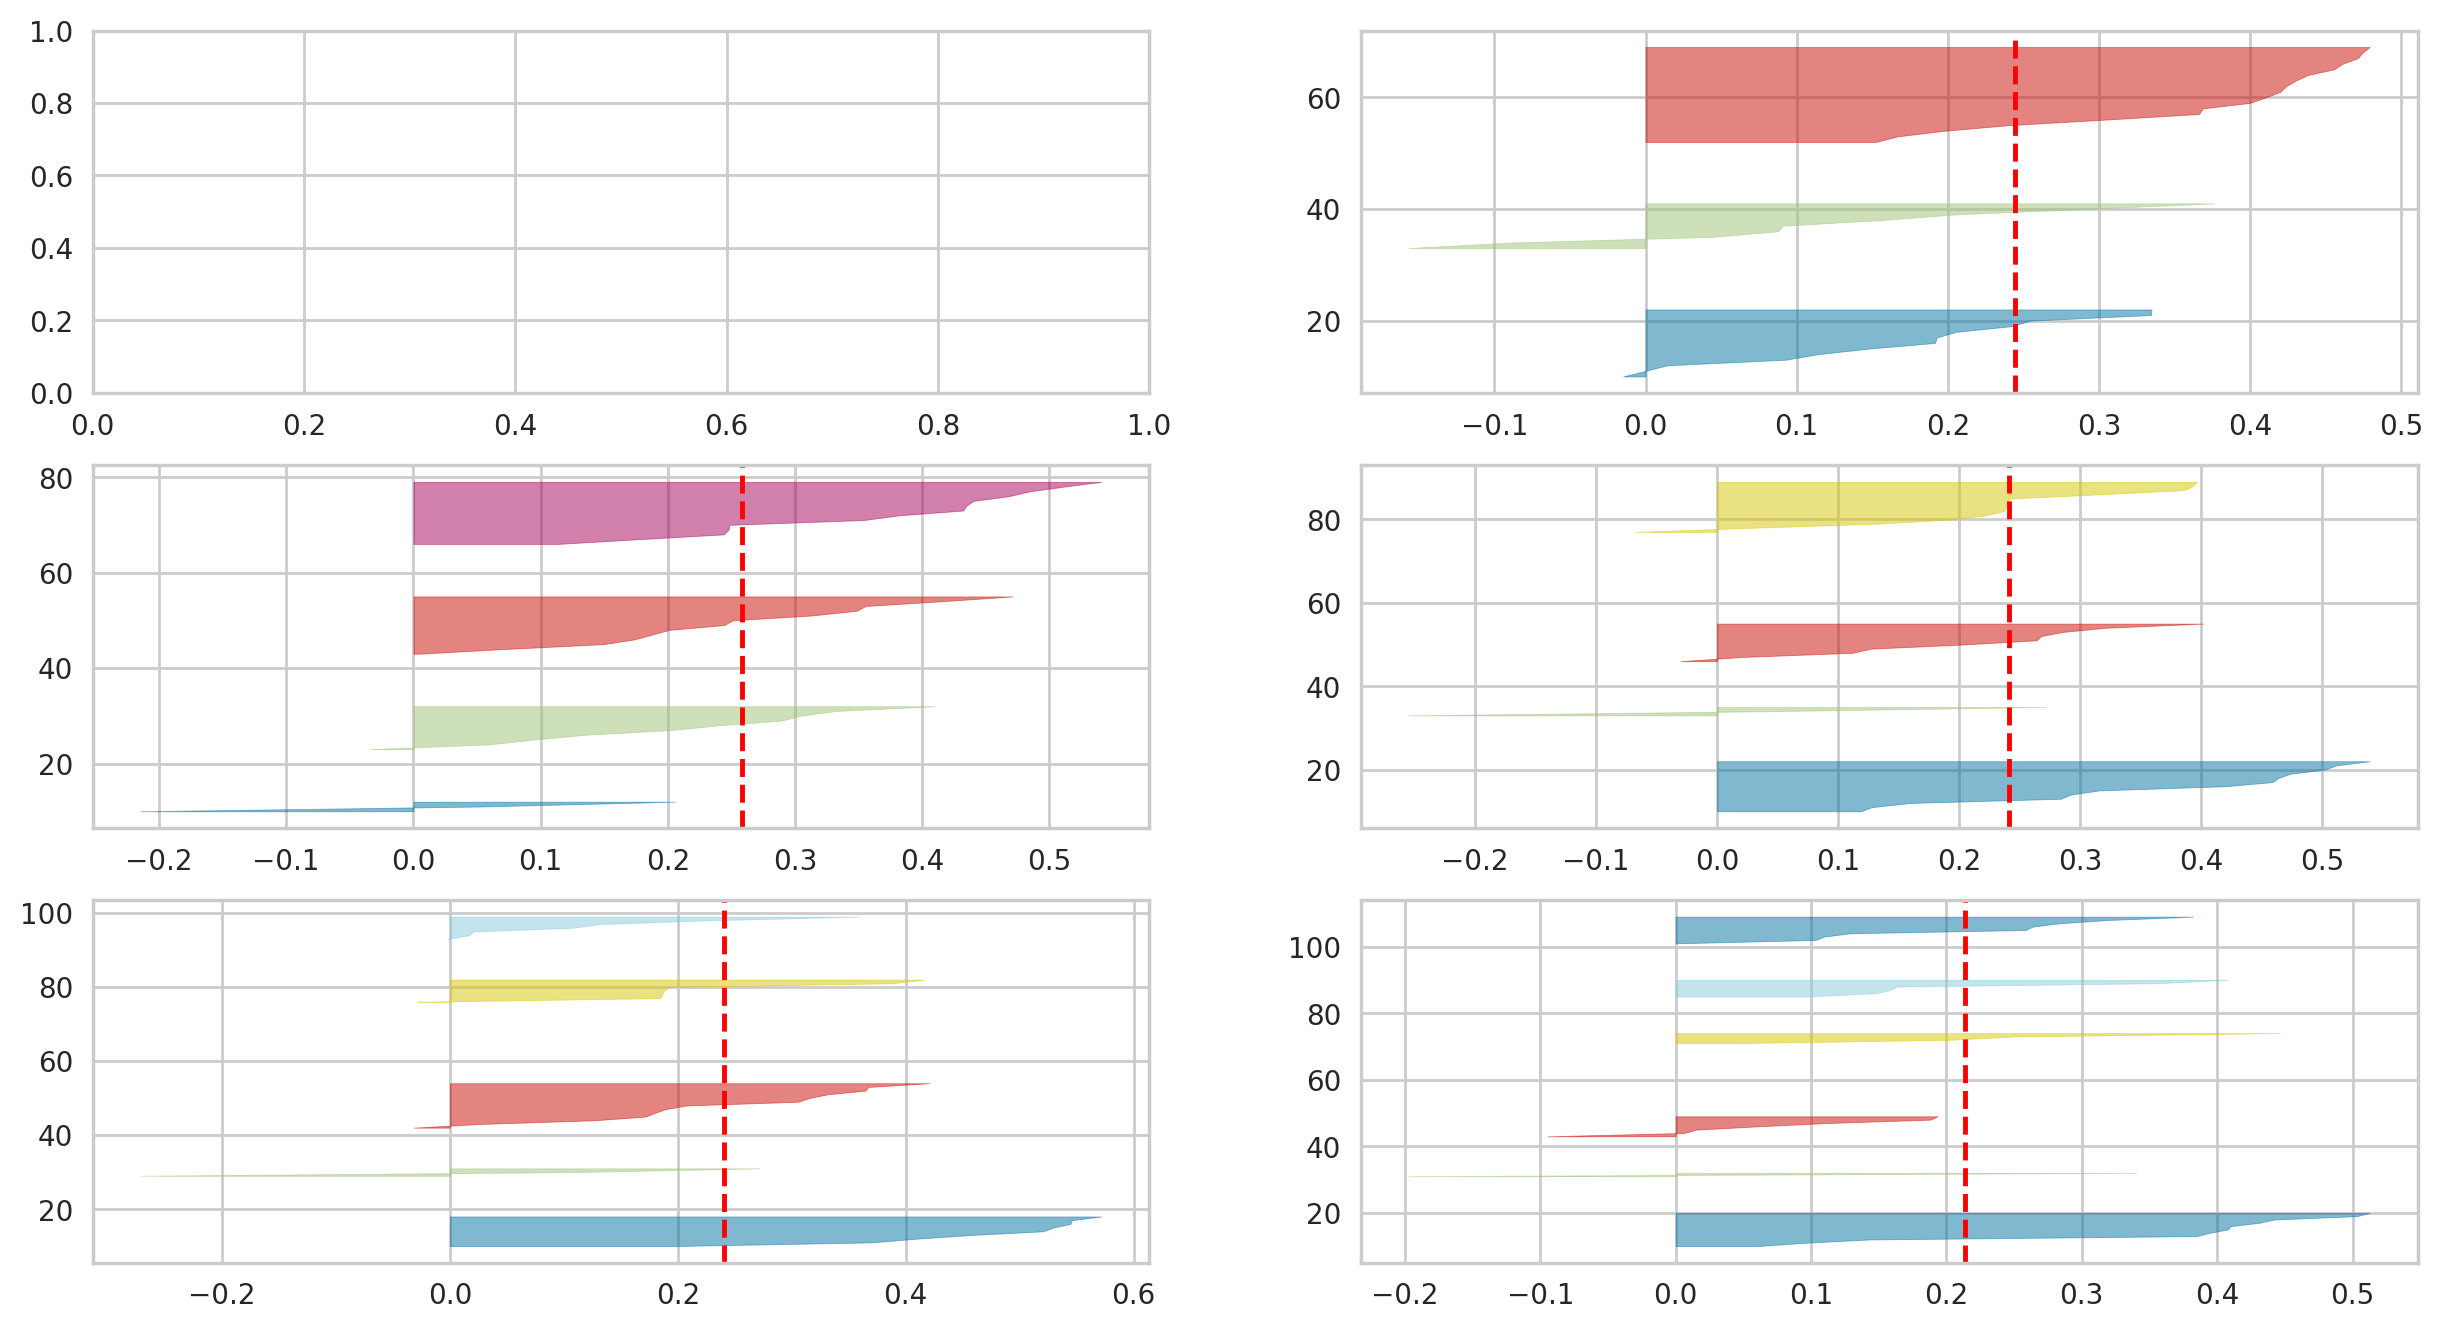

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer
nclust=8
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in range(3, nclust+1):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, **kmeans_kwargs)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_features) 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

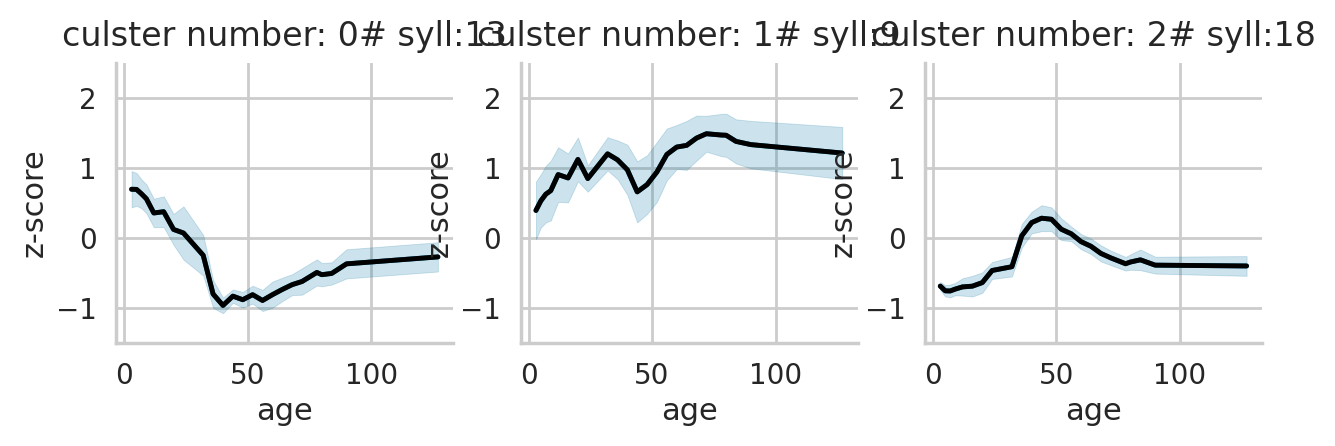

In [14]:
## plot everything for 4 cluster
nclust = 3
kmeans = KMeans(n_clusters=nclust, **kmeans_kwargs)
kmeans.fit_predict(scaled_features)
clust_labels = kmeans.labels_
n=0
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for i in range(nclust):
        temp = scaled_features[clust_labels==i].T  
        df = pd.DataFrame()
        df['z-score']=temp.T.flatten()
        df['age'] = np.shape(temp)[1] * list(data_labels)
        syll=list(range(np.shape(temp)[1]))
        df['syll'] = [ele for ele in syll for i in range(len(data_labels))]
        ax = plt.subplot(4, 4, n + 1)
        sns.lineplot(data=df, x='age', y='z-score', estimator='mean',errorbar='se')
        sns.lineplot(x=data_labels,y=np.mean(temp, axis=1), c='black')
        ax.set_title('culster number: ' + str(i) + '# syll:' + str(np.shape(temp)[1]))
        ax.set_ylim([-1.5,2.5])
        sns.despine()
        n=n+1

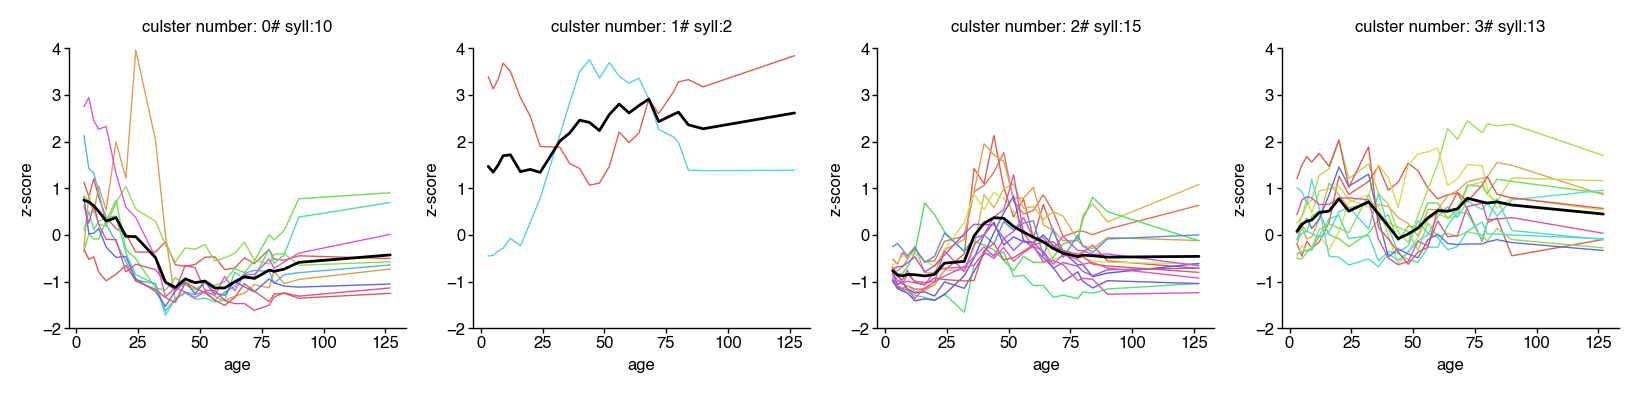

In [20]:
## plot everything for 4 cluster
format_plots()
nclust = 4
kmeans = KMeans(n_clusters=nclust, **kmeans_kwargs)
kmeans.fit_predict(scaled_features)
clust_labels = kmeans.labels_
n=0
fig=plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
syllables = np.array(range(40))

for i in range(nclust):
        temp = scaled_features[clust_labels==i].T  
        temp_syll=syllables[clust_labels==i].T
        df = pd.DataFrame()
        df['z-score']=temp.T.flatten()
        df['age'] = np.shape(temp)[1] * list(data_labels)
        syll=list(range(np.shape(temp)[1]))
        df['syll'] = [ele for ele in temp_syll for i in range(len(data_labels))]
        ax = plt.subplot(4, 4, n + 1)
        #sns.lineplot(data=df, x='age', y='z-score', hue='syll',legend='full', palette = 'hls', lw=0.5)
        sns.lineplot(data=df, x='age', y='z-score', hue='syll',legend=False, palette = 'hls', lw=0.5)
        sns.lineplot(x=data_labels,y=np.mean(temp, axis=1), c='black',ax=ax)
        ax.set_title('culster number: ' + str(i) + '# syll:' + str(np.shape(temp)[1]), fontsize=6)
        ax.set_ylim([-2,4])
        sns.despine()
        n=n+1

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'female_syll_clusters.pdf')

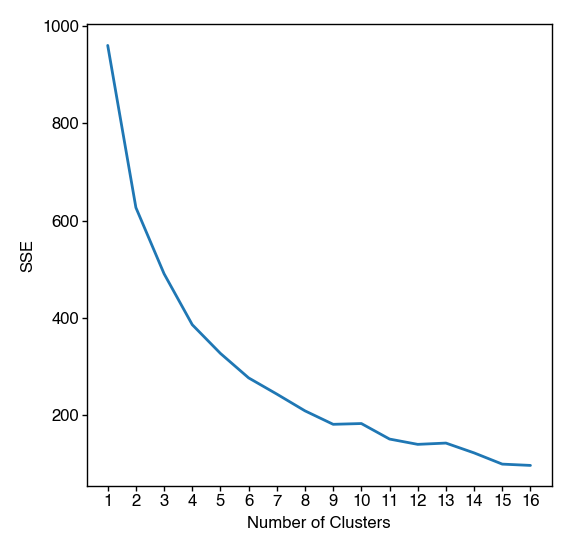

elbow point: SSE  5
elbow point: sill  3


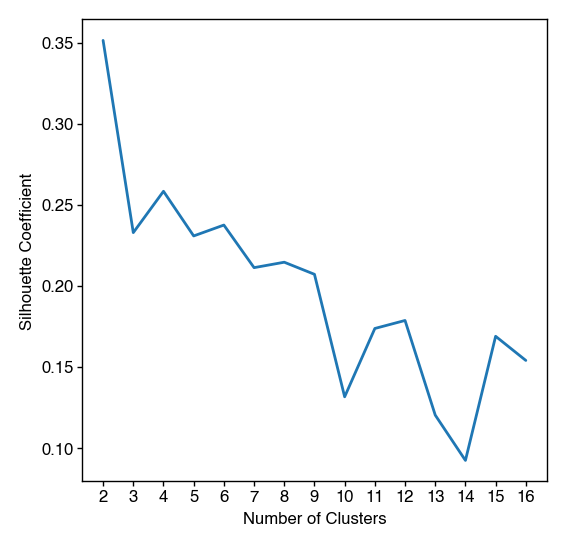

In [18]:
# explore number of clusters
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42}

# A list holds the SSE values for each k
sse = []
nclust=16
for k in range(1, nclust+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit_predict(scaled_features)
    sse.append(kmeans.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, nclust+1), sse)
plt.xticks(range(1, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# figure out elbow point
kl = KneeLocator(range(1, nclust+1), sse, curve="convex", direction="decreasing")
print('elbow point: SSE ', kl.elbow)

# second method
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, nclust+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(scaled_features)
    kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

kl = KneeLocator(range(2, nclust+1), silhouette_coefficients, curve="convex", direction="decreasing")
print('elbow point: sill ', kl.elbow)

#plt.style.use("seaborn")
plt.plot(range(2, nclust+1), silhouette_coefficients)
plt.xticks(range(2, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

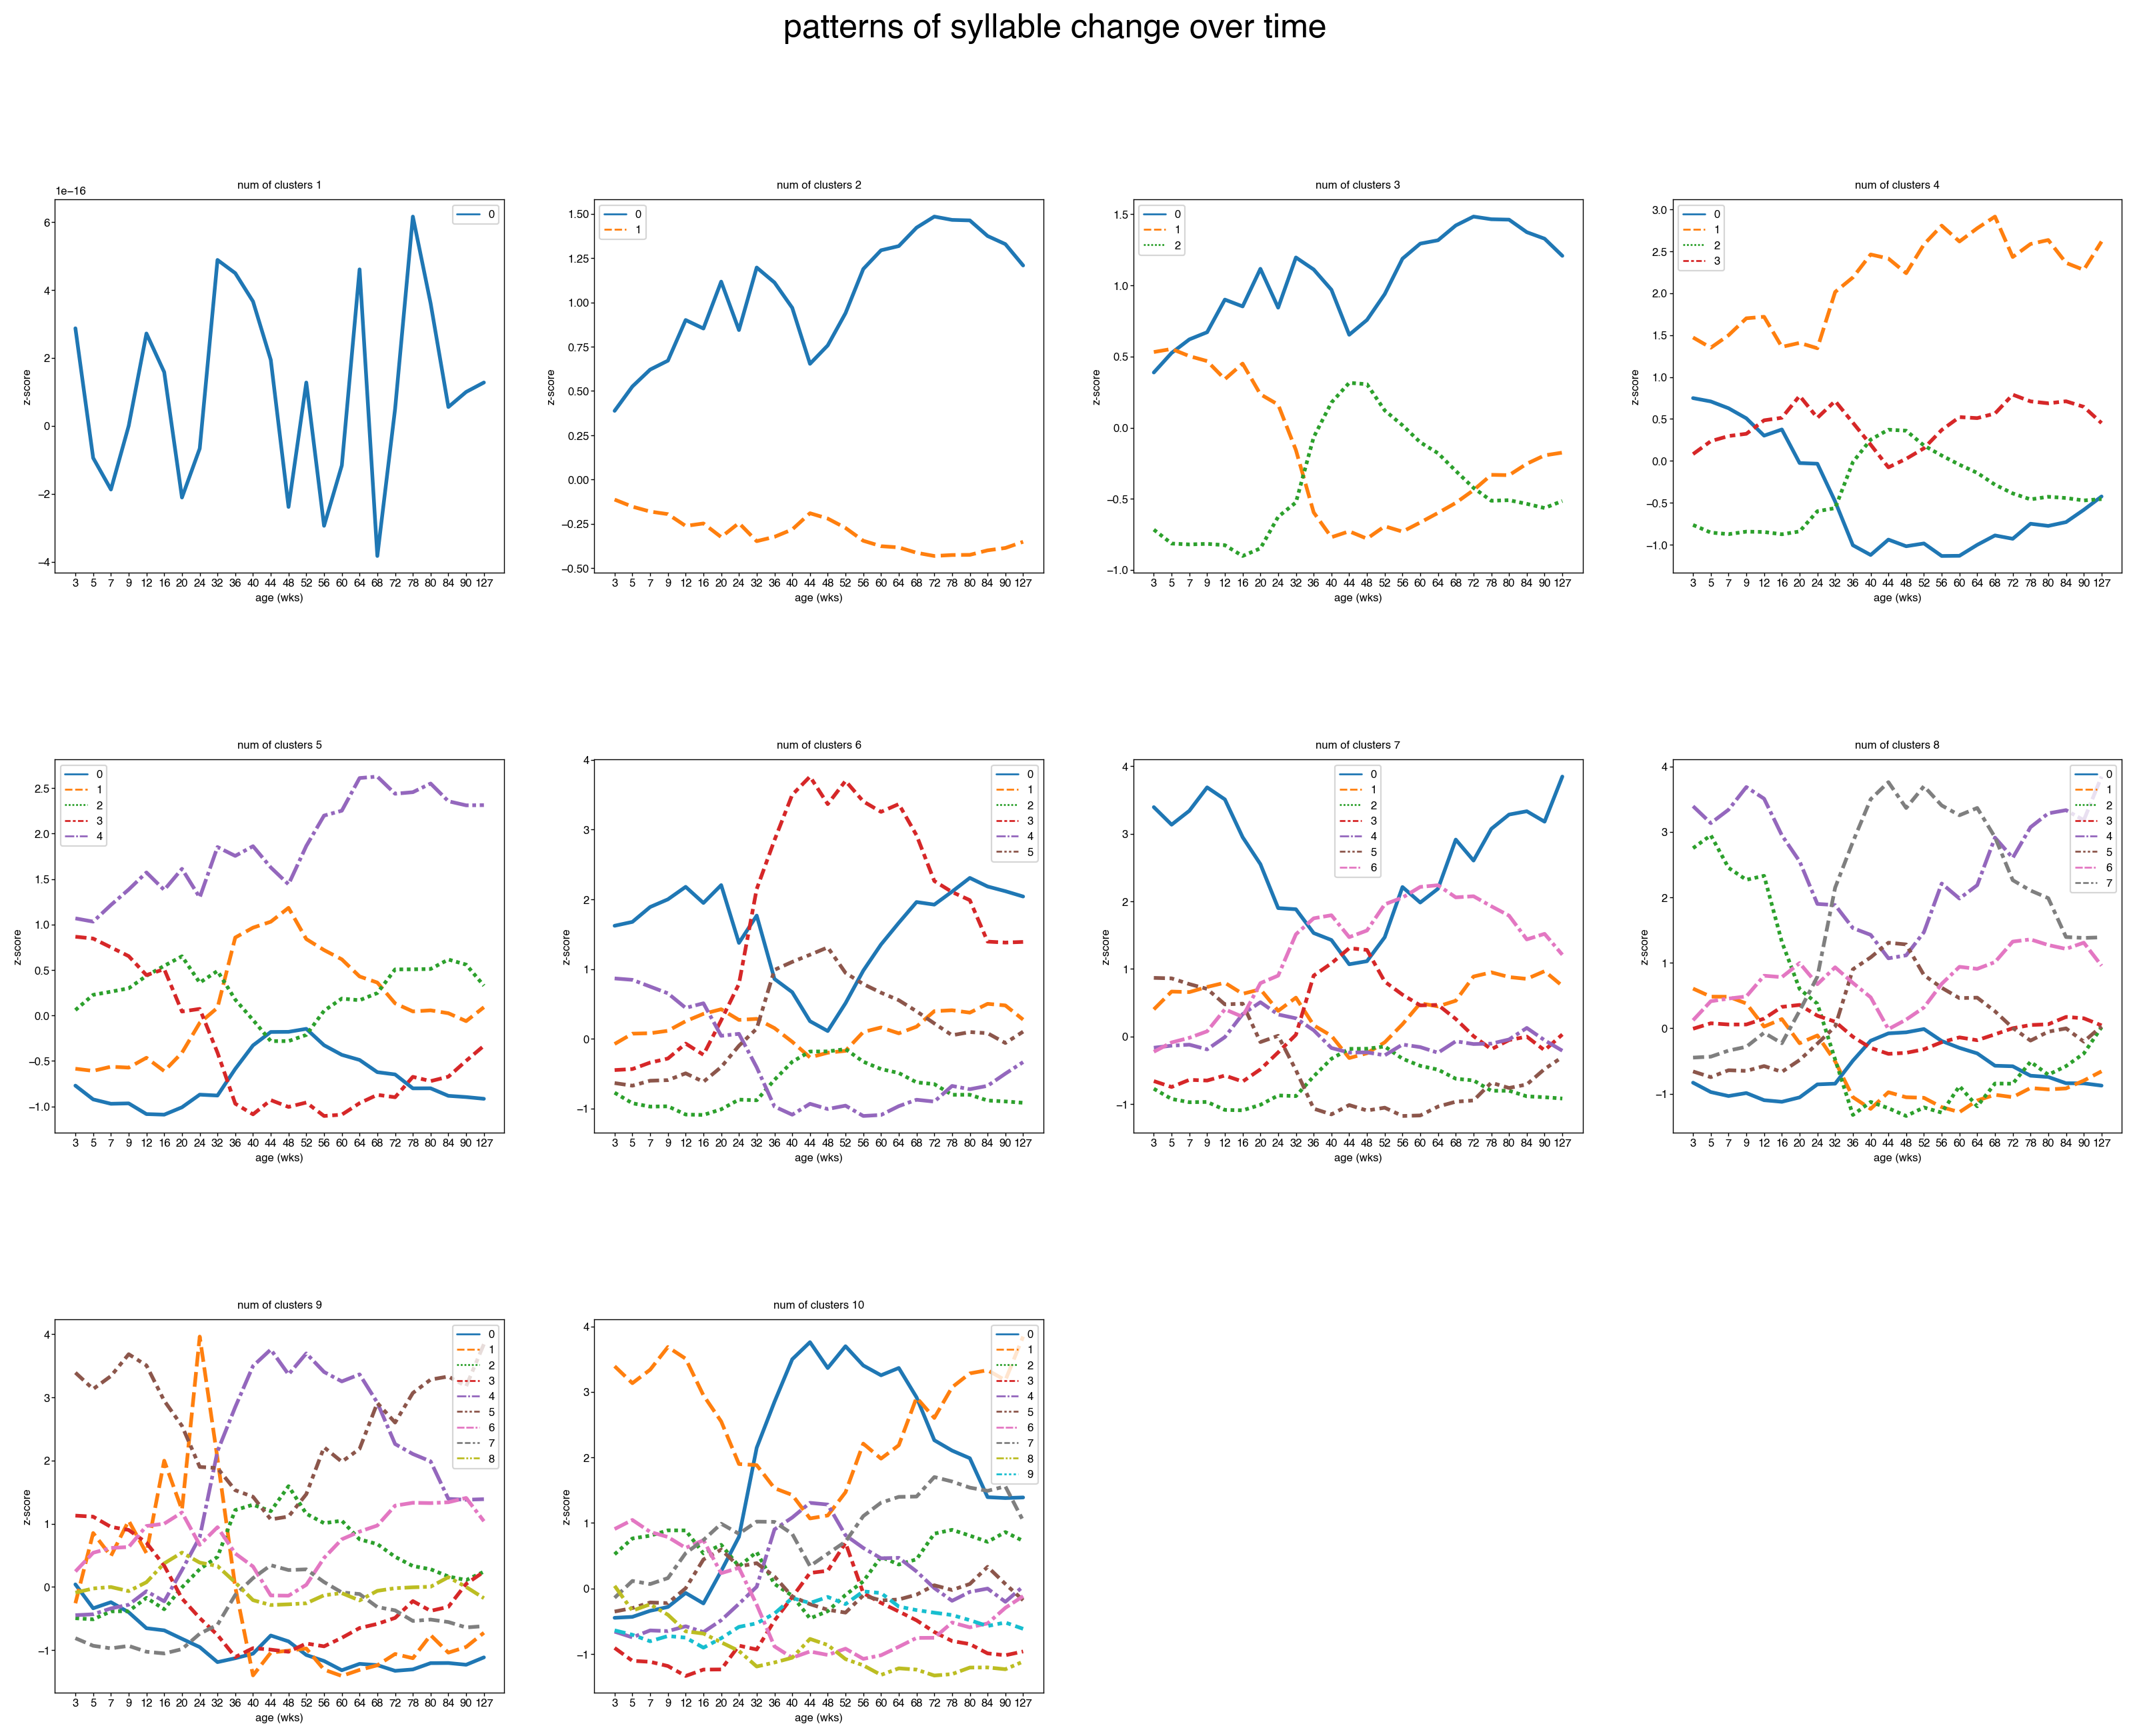

In [19]:
## explore number of possible clusters
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("patterns of syllable change over time", fontsize=18, y=0.95)
n=0
nclust=10
for k in range(1, nclust+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit_predict(scaled_features)
    ax = plt.subplot(4, 4, n + 1)
    sns.lineplot(kmeans.cluster_centers_.T, lw=2)
    ax.set_title('num of clusters ' + str(k))
    ax.set_xlabel("age (wks)")
    ax.set_ylabel("z-score")
    ax.set_xticks(range(len(data_labels))) # <--- set the ticks first
    ax.set_xticklabels(data_labels)
    n=n+1